# Day 10 - Inference, Predictor Significance & Classification Metrics

This notebook demonstrates the core concepts of statistical inference discussed in Day 10 of the Data Science Series. We'll use the space missions dataset to explore:

1.  **Confidence Intervals**
2.  **Bootstrapping**
3.  **Hypothesis Testing**
4.  **Classification Metrics**

## Load Data

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


# Set plot style
sns.set_style('whitegrid')

# Load the dataset
df = pd.read_csv('/Users/amrithaa/Downloads/12DayDataSeries/notebooks/data/encoded_data.csv')

## Confidence Intervals (CIs)

A **Confidence Interval** gives us a range of plausible values for a population parameter (like the mean) with a certain level of confidence. For example, a 95% CI means if we were to repeat our sampling process 100 times, we'd expect the true population mean to fall within our calculated interval 95 times.

Let's calculate the 95% CI for the average **mission cost**.

In [55]:
# Extract the mission cost data
mission_cost = df['mission_cost_millions'].dropna()

# Calculate sample statistics
sample_mean = mission_cost.mean()
sample_std = mission_cost.std()
n = len(mission_cost)
standard_error = sample_std / np.sqrt(n)

# Calculate the 95% Confidence Interval for the mean
# We use the t-distribution because the population standard deviation is unknown
confidence_level = 0.95
degrees_freedom = n - 1

ci_lower, ci_upper = stats.t.interval(confidence_level, degrees_freedom, loc=sample_mean, scale=standard_error)

print(f"Sample Mean Mission Cost: ${sample_mean:,.2f} million")
print(f"95% Confidence Interval for Mean Mission Cost: (${ci_lower:,.2f} million, ${ci_upper:,.2f} million)")
print(f"\nWe are 95% confident that the true average cost for all \nspace missions is between ${ci_lower:,.2f} and ${ci_upper:,.2f} million.")

Sample Mean Mission Cost: $253.60 million
95% Confidence Interval for Mean Mission Cost: ($243.54 million, $263.66 million)

We are 95% confident that the true average cost for all 
space missions is between $243.54 and $263.66 million.


## Bootstrapping

**Bootstrapping** is a powerful resampling method that lets us estimate the uncertainty of a statistic (like the mean or median) by generating many new samples from our original sample. We do this by **sampling with replacement**.

Let's use bootstrapping to find a 95% confidence interval for the mean **mission success score**.

Original Sample Mean Success Score: 85.47
Bootstrapped 95% CI for Mean Success Score: (84.53, 86.40)


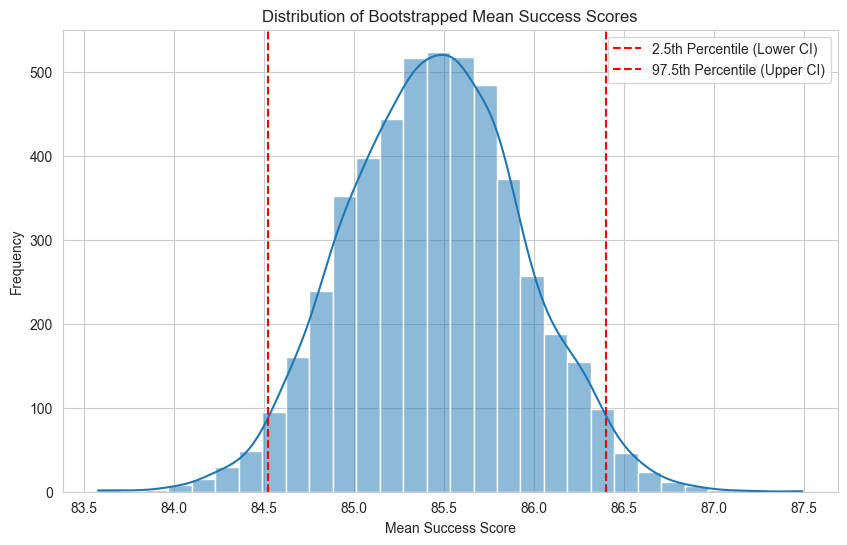

In [56]:
# Extract the mission success score data
success_score = df['mission_success_score'].dropna()

# Number of bootstrap samples to create
n_iterations = 5000
bootstrapped_means = []

# Perform bootstrapping
for i in range(n_iterations):
    # Create a new sample by sampling with replacement
    bootstrap_sample = success_score.sample(n=len(success_score), replace=True)
    # Calculate the mean of the new sample and store it
    bootstrapped_means.append(bootstrap_sample.mean())

# Calculate the 95% CI from the bootstrapped distribution
ci_lower_boot = np.percentile(bootstrapped_means, 2.5)
ci_upper_boot = np.percentile(bootstrapped_means, 97.5)

print(f"Original Sample Mean Success Score: {success_score.mean():.2f}")
print(f"Bootstrapped 95% CI for Mean Success Score: ({ci_lower_boot:.2f}, {ci_upper_boot:.2f})")

# Visualize the distribution of bootstrapped means
plt.figure(figsize=(10, 6))
sns.histplot(bootstrapped_means, kde=True, bins=30)
plt.axvline(ci_lower_boot, color='red', linestyle='--', label='2.5th Percentile (Lower CI)')
plt.axvline(ci_upper_boot, color='red', linestyle='--', label='97.5th Percentile (Upper CI)')
plt.title('Distribution of Bootstrapped Mean Success Scores')
plt.xlabel('Mean Success Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


## Hypothesis Testing

**Hypothesis Testing** is a formal procedure to check if our findings are statistically significant or if they could have occurred by chance. We start with a **null hypothesis ($H_0$)** (e.g., "there is no effect") and look for evidence to reject it.

- **T-score**: Measures how many standard errors our sample statistic is from the null hypothesis value.
- **P-value**: The probability of observing our data (or more extreme) if the null hypothesis is true. A small p-value (typically < 0.05) suggests we can reject the null hypothesis.

### Test 1: One-Sample T-test
Let's test if the average `mission_success_score` is significantly different from a hypothetical benchmark of 70.

- **$H_0$**: The true mean success score is 70.
- **$H_a$**: The true mean success score is **not** 70.

In [57]:
hypothetical_mean = 70.0

t_statistic, p_value = stats.ttest_1samp(success_score, hypothetical_mean)

print(f"One-Sample T-Test Results (H0: mean_score = {hypothetical_mean}):")
print(f"T-statistic: {t_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("\nConclusion: The p-value is less than 0.05, so we reject the null hypothesis.\nThe mean success score is significantly different from 70.")
else:
    print("\nConclusion: The p-value is not less than 0.05, so we fail to reject the null hypothesis.\nThere is not enough evidence to say the mean success score is different from 70.")

One-Sample T-Test Results (H0: mean_score = 70.0):
T-statistic: 31.2519
P-value: 0.0000

Conclusion: The p-value is less than 0.05, so we reject the null hypothesis.
The mean success score is significantly different from 70.


### Test 2: Two-Sample T-test
Now, let's test if there is a significant difference in the `mission_cost_millions` between successful and failed missions.

- **$H_0$**: The mean cost of successful missions is equal to the mean cost of failed missions.
- **$H_a$**: The mean costs are **not** equal.

In [58]:
# Split the data into two groups based on mission outcome
cost_success = df[df['mission_outcome'] == 'Success']['mission_cost_millions'].dropna()
cost_failure = df[df['mission_outcome'] == 'Failure']['mission_cost_millions'].dropna()

# Perform the two-sample t-test
t_stat_2, p_value_2 = stats.ttest_ind(cost_success, cost_failure)

print(f"Two-Sample T-Test Results (Cost of Success vs. Failure):")
print(f"Mean cost of successful missions: ${cost_success.mean():.2f}M")
print(f"Mean cost of failed missions: ${cost_failure.mean():.2f}M")
print(f"T-statistic: {t_stat_2:.4f}")
print(f"P-value: {p_value_2:.4f}")

if p_value_2 < 0.05:
    print("\nConclusion: The p-value is less than 0.05, so we reject the null hypothesis.\nThere is a statistically significant difference in cost between successful and failed missions.")
else:
    print("\nConclusion: The p-value is not less than 0.05, so we fail to reject the null hypothesis.\nThere is no significant difference in cost.")

Two-Sample T-Test Results (Cost of Success vs. Failure):
Mean cost of successful missions: $251.87M
Mean cost of failed missions: $357.39M
T-statistic: -2.6423
P-value: 0.0085

Conclusion: The p-value is less than 0.05, so we reject the null hypothesis.
There is a statistically significant difference in cost between successful and failed missions.


## Classification Metrics

When we build a predictive model for a categorical outcome (like `Success` or `Failure`), we need metrics to evaluate its performance. These metrics are all built from four basic outcomes that can be visualized in a **Confusion Matrix**.

### Understanding the Confusion Matrix: TP, TN, FP, FN

Let's define our terms for the space mission example:
* **Positive Class**: A successful mission (`Success`). This is the primary outcome we want to find.
* **Negative Class**: A failed mission (`Failure`).

For every prediction the model makes, there are four possibilities:

🟩 **True Positive (TP)**
* **What it is**: The model correctly predicted the positive class.
* **Our Example**: A mission was actually a **Success**, and the model correctly predicted **"Success"**.
* **In short**: A correct "yes" prediction.

🟩 **True Negative (TN)**
* **What it is**: The model correctly predicted the negative class.
* **Our Example**: A mission was actually a **Failure**, and the model correctly predicted **"Failure"**.
* **In short**: A correct "no" prediction.

🟥 **False Positive (FP) - Type I Error**
* **What it is**: The model incorrectly predicted the positive class.
* **Our Example**: A mission was actually a **Failure**, but the model incorrectly predicted **"Success"**.
* **In short**: A false alarm. The model cried wolf.

🟥 **False Negative (FN) - Type II Error**
* **What it is**: The model incorrectly predicted the negative class.
* **Our Example**: A mission was actually a **Success**, but the model incorrectly predicted **"Failure"**.
* **In short**: A miss. The model failed to detect what it was looking for.

---

### TP, TN, FP, and FN Create Key Metrics:

- **Accuracy**: Overall, how often is the model correct?
    - `(TP + TN) / (Total Predictions)`
    - This can be misleading if the dataset is imbalanced (e.g., way more successes than failures).

- **Precision**: Of all the missions we *predicted* as successful, how many actually were?
    - `TP / (TP + FP)`
    - **Why it matters**: High precision is crucial when the cost of a **False Positive** is high. You don't want to celebrate a failed mission as a success.

- **Recall (or Sensitivity)**: Of all the missions that were *actually* successful, how many did we find?
    - `TP / (TP + FN)`
    - **Why it matters**: High recall is crucial when the cost of a **False Negative** is high. You don't want to miss a truly successful mission design and mistakenly discard it.

- **F1-Score**: The harmonic mean of Precision and Recall.
    - `2 * (Precision * Recall) / (Precision + Recall)`
    - It provides a single score that balances the trade-off between precision and recall, and is particularly useful for imbalanced datasets.

Now, let's train a simple Logistic Regression model to predict `mission_outcome` and evaluate it using these metrics.

--- Classification Metrics ---

Classification Report:
              precision    recall  f1-score   support

     Failure       0.67      1.00      0.80         2
     Success       1.00      0.99      1.00       126

    accuracy                           0.99       128
   macro avg       0.83      1.00      0.90       128
weighted avg       0.99      0.99      0.99       128


Confusion Matrix:


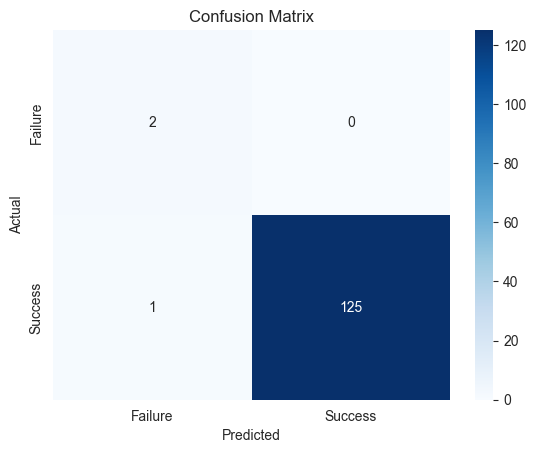

In [59]:
# 1. Prepare the data
features = ['crew_size', 'mission_duration_days', 'mission_cost_millions', 'risk_score', 'mental_health_score']
target = 'mission_outcome'

# Drop rows with any missing values in these columns for simplicity
model_df = df[features + [target]].dropna()

# Convert target to numerical (0 for Failure, 1 for Success)
model_df['target_numeric'] = model_df[target].apply(lambda x: 1 if x == 'Success' else 0)

X = model_df[features]
y = model_df['target_numeric']

# 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 3. Train a classification model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 4. Make predictions on the test set
y_pred = model.predict(X_test)

# 5. Evaluate the model
print("--- Classification Metrics ---")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Failure', 'Success']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Failure', 'Success'], yticklabels=['Failure', 'Success'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

## Conclusion

This notebook provided a practical walkthrough of key statistical inference techniques. From quantifying uncertainty with **confidence intervals** and **bootstrapping**, to formally testing claims with **hypothesis testing**, and finally evaluating model performance with **classification metrics**, these tools are essential for any data scientist looking to draw reliable conclusions from data.

And now, it's time we bid goodbye. 

Until next time. 🚀